<a href="https://colab.research.google.com/github/annafumagalli/LISA-M-project/blob/master/CDAE_noisy_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab routines

In [1]:
!pip3 install torch

In [2]:
!git clone https://github.com/annafumagalli/LISA-M-project.git

fatal: destination path 'LISA-M-project' already exists and is not an empty directory.


In [3]:
cd ./LISA-M-project

/content/LISA-M-project


---------------------------------

In [0]:
%matplotlib inline
import numpy as np
from scipy.signal import chirp
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchsummary import summary

from CDAE_model import *
from CDAE_training import *

import copy
import random

In [5]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Training datasets

Randomly generate different type of signals within fixed parameter ranges and mix them together to create traning datasets.

- 100 mixed signals + clean/target sources signals
- These datasets will have added gaussian noise

In [0]:
def normalise(x):
    y = (x - x.min())/(x.max() - x.min())
    return y

In [0]:
# Fixed dataset parameters

n = 1000      # number of training sets per batch
T = 60*10     # 10 min of data, sampled every 0.1 s
fs = 10       # sampling frequency
N = T*fs
t = np.linspace(0,T,N)

# FFT parameters

NFFT = 20*fs   # FTT time interval
NOVL = NFFT*0.71      # overlap
window = np.blackman(NFFT) 

# Noise parameters

mean = 0.0
sd = 0.7

## Sine waves

In [20]:
# Fixed:
# amplitude
a = 1.0 

# Varying:
# frequency
freq_sin = np.random.uniform(1.0, 4.0, n)

# Time Series

ts_s_train = np.zeros((n,N))
ts_noisy_s_train = np.zeros((n,N))
for i in range(n):
    
    noise = np.random.normal(mean, sd, N)
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t)
    ts_noisy_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t)+noise
    
    
# Spectrograms

s_train = []
noisy_s_train = []
for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    s_train.append(temp1)
    temp2, _, _ = plt.mlab.specgram(ts_noisy_s_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    noisy_s_train.append(temp2)

s_train = np.array(s_train)
s_train = s_train[:,:100,:100]
noisy_s_train = np.array(noisy_s_train)
noisy_s_train = noisy_s_train[:,:100,:100]

s_train.shape

(1000, 100, 100)

## Sine Gaussians

In [21]:
# Fixed:
# amplitude
a = 1.0
# envelope parameter
tau = 40.0
#frequency
freq_sg = 4.5

# Varying:
# pulse starting time
t0_sg = np.random.uniform(100.0, 200.0, n)


# Time Series

ts_sg_train = np.zeros((n,N))
ts_noisy_sg_train = np.zeros((n,N))
for i in range(n):
    
    noise = np.random.normal(mean, sd, N)
    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*freq_sg*(t-t0_sg[i])))
    ts_noisy_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*freq_sg*(t-t0_sg[i])))+noise
    
# Spectrograms

sg_train = []
noisy_sg_train = []
for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_sg_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    sg_train.append(temp1)
    temp2, _, _ = plt.mlab.specgram(ts_noisy_sg_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    noisy_sg_train.append(temp2)
    
sg_train = np.array(sg_train)
sg_train = sg_train[:,:100,:100]
noisy_sg_train = np.array(noisy_sg_train)
noisy_sg_train = noisy_sg_train[:,:100,:100]

sg_train.shape

(1000, 100, 100)

## Chirps

In [22]:
# Fixed:
# amplitude
a = 1.0
# Chirping time
t1 = 350.0

# Varying:
# Chirp frequencies
f0 = np.random.uniform(0.5, 1.5, n)
f1 = np.random.uniform(1.5, 2.5, n)

# Time Series

ts_chirp_train = np.zeros((n,N))
ts_noisy_chirp_train = np.zeros((n,N))
for i in range(n):
    
    noise = np.random.normal(mean, sd, N)
    k = (f1[i]/f0[i])**(1/(t1))
    ts_chirp_train[i,:] =  a*np.sin(2.0*np.pi*f0[i]*((k**t-1)/np.log(k)))
    ts_noisy_chirp_train[i,:] =  a*np.sin(2.0*np.pi*f0[i]*((k**t-1)/np.log(k)))+noise
    
# Spectrograms

chirp_train = []
noisy_chirp_train = []
for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_chirp_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    chirp_train.append(temp1)
    temp2, _, _ = plt.mlab.specgram(ts_noisy_chirp_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    noisy_chirp_train.append(temp2)    
    
chirp_train = np.array(chirp_train)
chirp_train = chirp_train[:,:100,:100]
noisy_chirp_train = np.array(noisy_chirp_train)
noisy_chirp_train = noisy_chirp_train[:,:100,:100]

chirp_train.shape

(1000, 100, 100)

## Mixtures

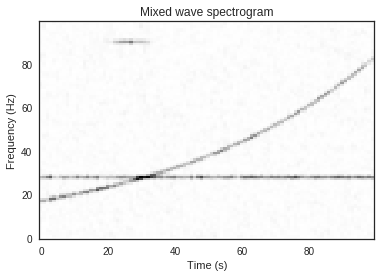

11.502383188197896 8.248559250356354e-18


In [23]:
# Sine + sine gaussian + chirp

mix_train = s_train + sg_train + chirp_train
noisy_mix_train = noisy_s_train + noisy_sg_train + noisy_chirp_train

plt.imshow(normalise(noisy_mix_train[10]), aspect='auto', origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mixed wave spectrogram')

plt.show()

print(mix_train.max(), mix_train.min())

In [0]:
# Normalise data arrays between [0, 1] for training

s_train = normalise(s_train)
sg_train = normalise(sg_train)
chirp_train = normalise(chirp_train)
mix_train = normalise(mix_train)

noisy_s_train = normalise(noisy_s_train)
noisy_sg_train = normalise(noisy_sg_train)
noisy_chirp_train = normalise(noisy_chirp_train)
noisy_mix_train = normalise(noisy_mix_train)

In [0]:
spec_size=(mix_train.shape[1], mix_train.shape[2])

print(spec_size)

(126, 56)


# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

In [0]:
model = CDAE().to(device)

summary(model, (1, 126, 56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 10, 126, 56]           1,690
              Tanh-2          [-1, 10, 126, 56]               0
         MaxPool2d-3           [-1, 10, 42, 28]               0
            Conv2d-4           [-1, 20, 42, 28]           1,800
              Tanh-5           [-1, 20, 42, 28]               0
         MaxPool2d-6           [-1, 20, 14, 14]               0
            Conv2d-7           [-1, 30, 14, 14]           5,400
              Tanh-8           [-1, 30, 14, 14]               0
            Conv2d-9           [-1, 40, 14, 14]          10,800
             Tanh-10           [-1, 40, 14, 14]               0
  ConvTranspose2d-11           [-1, 30, 42, 28]           7,200
             Tanh-12           [-1, 30, 42, 28]               0
  ConvTranspose2d-13          [-1, 20, 126, 56]           3,600
             Tanh-14          [-1, 20, 

# Training

start training...
epoch 0, loss 0.01034980546683073


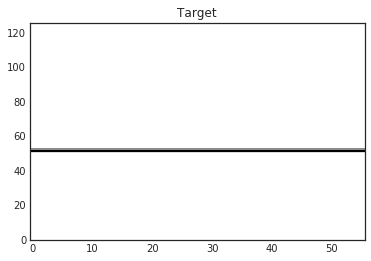

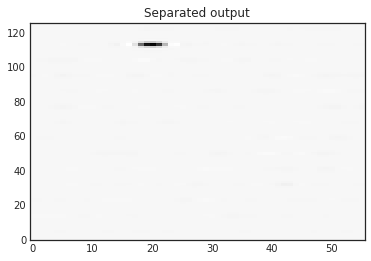

epoch 1000, loss 0.00019938529294449836


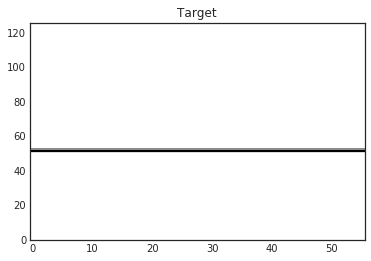

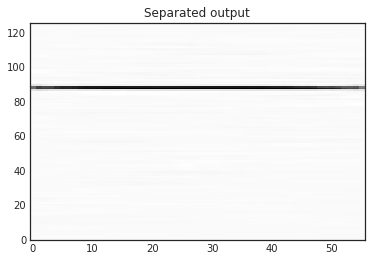

epoch 2000, loss 0.00013320813013706356


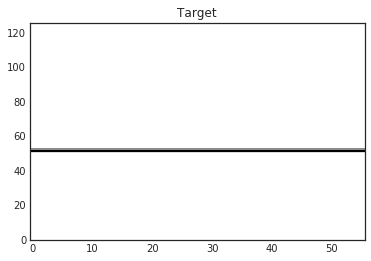

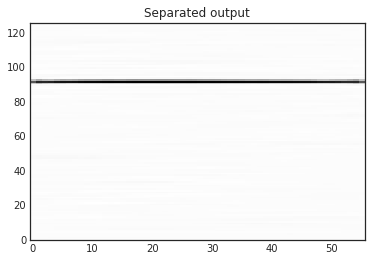

epoch 3000, loss 0.00011866928252857178


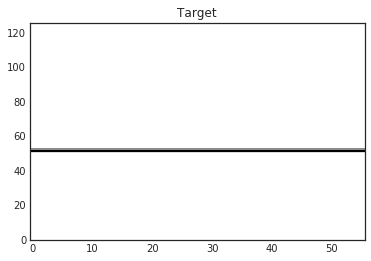

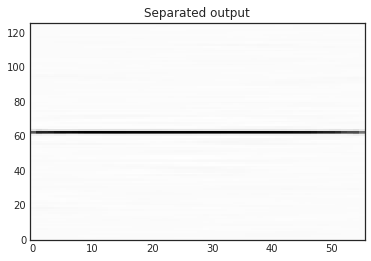

epoch 4000, loss 0.00012216728646308184


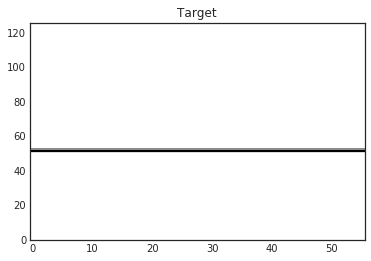

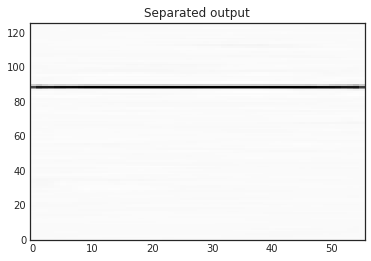

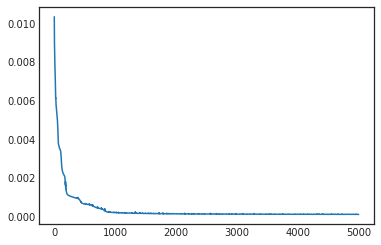

Saving trained model...
Model noisy_s_net_05-02-2019_17:36:58.pt saved.


In [0]:
# Sine

trainer = CDAE_trainer(model=model,
                       path='/home/annaf/LDC_project/masters_project/saved_models',
                       filename='noisy_s_net')

print('start training...')
trainer.train(mixed_input=noisy_mix_train,
              target=s_train,
              n=n,
              device=device,
              batch_size=100,
              epochs=5000,
              H=spec_size[0],
              W=spec_size[1])

start training...
epoch 0, loss 0.010200954042375088


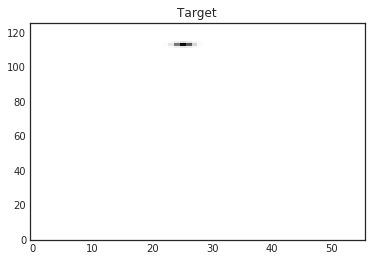

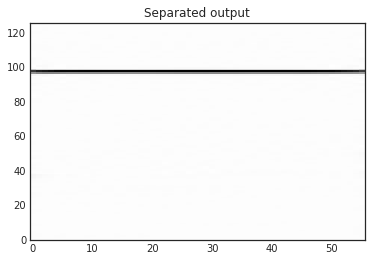

epoch 1000, loss 0.00013980593939777464


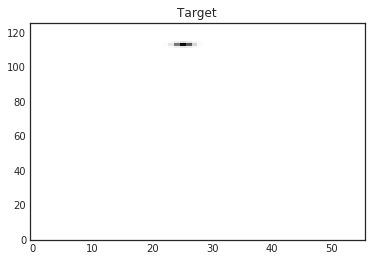

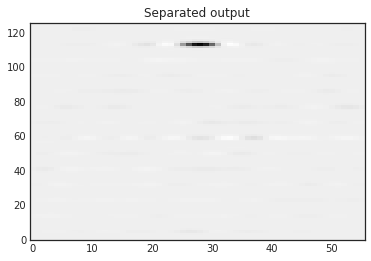

epoch 2000, loss 7.581068348372355e-05


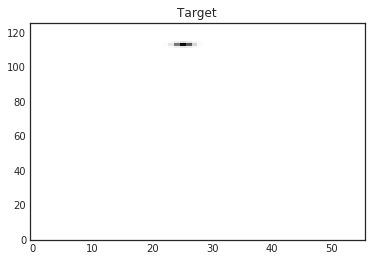

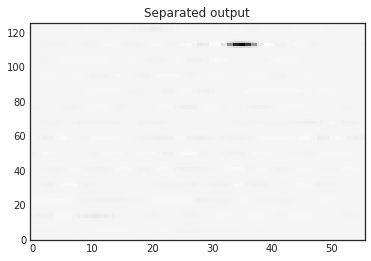

epoch 3000, loss 5.920818875893019e-05


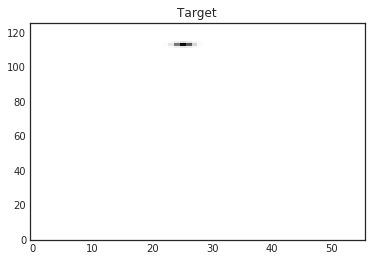

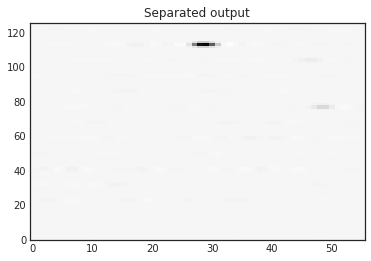

epoch 4000, loss 5.453303674585186e-05


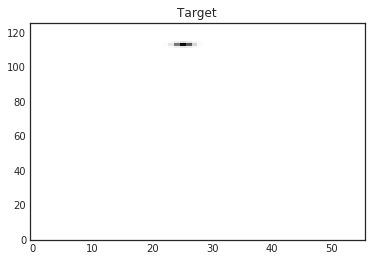

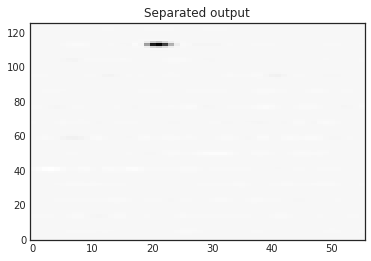

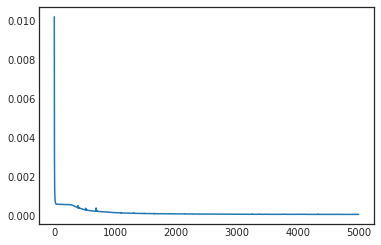

Saving trained model...
Model noisy_sg_net_05-02-2019_17:34:03.pt saved.


In [0]:
# Sine gaussian

trainer = CDAE_trainer(model=model,
                       path='/home/annaf/LDC_project/masters_project/saved_models',
                       filename='noisy_sg_net')

print('start training...')
trainer.train(mixed_input=noisy_mix_train,
              target=sg_train,
              n=n,
              device=device,
              batch_size=100,
              epochs=5000,
              H=spec_size[0],
              W=spec_size[1])

start training...
epoch 0, loss 0.01716027408838272


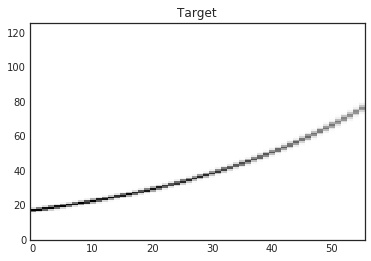

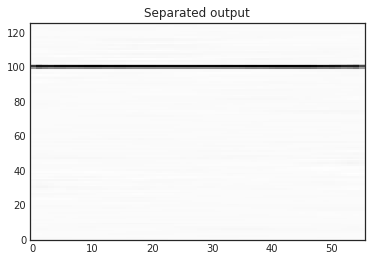

epoch 1000, loss 0.0005614023539237678


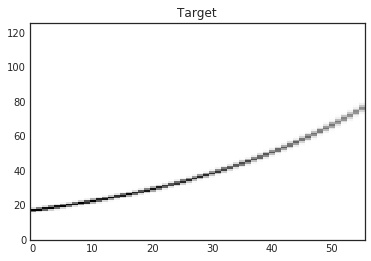

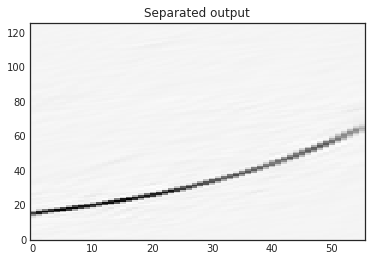

epoch 2000, loss 0.0004129005828872323


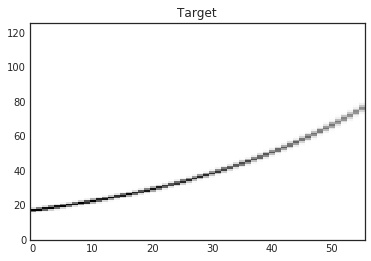

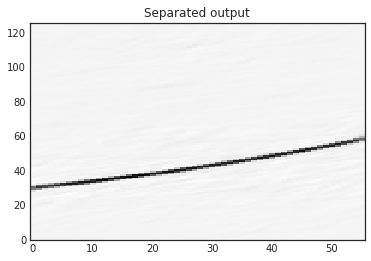

epoch 3000, loss 0.0003584289224818349


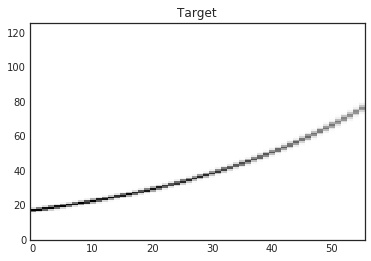

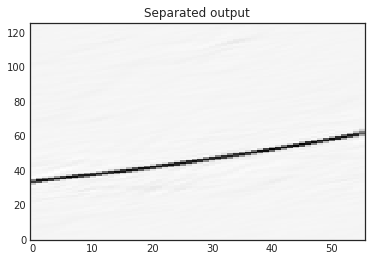

epoch 4000, loss 0.00033830388565547764


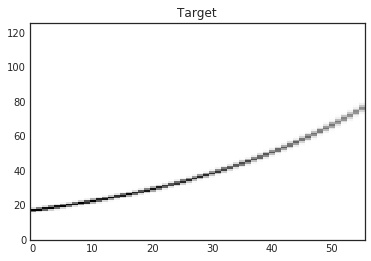

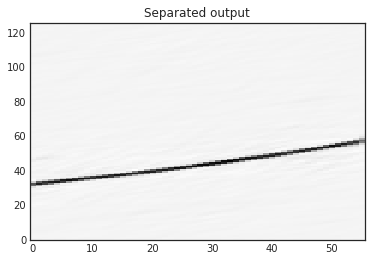

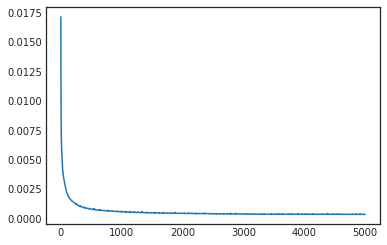

Saving trained model...
Model noisy_chirp_net_05-02-2019_17:38:20.pt saved.


In [0]:
# Chirp

trainer = CDAE_trainer(model=model,
                       path='/home/annaf/LDC_project/masters_project/saved_models',
                       filename='noisy_chirp_net')

print('start training...')
trainer.train(mixed_input=noisy_mix_train,
              target=chirp_train,
              n=n,
              device=device,
              batch_size=100,
              epochs=5000,
              H=spec_size[0],
              W=spec_size[1])